In [3]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import tifffile
import json
import os

# Create fake images

In [84]:
files = glob.glob('../images/val/data/comet_*.mat')
metainfo = ['PolAng', 'TipProb', 'ExpTime', 'TipExp', 'eNoise']

In [85]:
def disp(stats, key):
    print(f'{key}: {np.min(stats[key])}-{np.max(stats[key])} {np.mean(stats[key]):.2f}')
    
def print_stats(files):
    stats = {'MinPixel': [], 'MaxPixel': []}
    min_int, max_int = [], []
    for file in files:
        src = loadmat(file, squeeze_me=True)
        stats['MinPixel'].append(src['M'].min())
        stats['MaxPixel'].append(src['M'].max())
        for key in metainfo:
            if key not in stats:
                stats[key] = []
            stats[key].append(src[key])
    
    for key in stats.keys():
        disp(stats, key)

In [86]:
print_stats(files)

MinPixel: 338-371 359.65
MaxPixel: 421-854 566.88
PolAng: 0-90 46.67
TipProb: 0.505-0.899 0.71
ExpTime: 50-150 99.97
TipExp: 50-350 186.25
eNoise: 50-247 146.47


In [87]:
def save_tif(ifilename, ofilename, subpixel=0):
    src = loadmat(ifilename, squeeze_me=True)
    
    metadata = {}
    for key in metainfo:
        metadata[key] = src[key]

    extra_tags = [("MicroManagerMetadata", 's', 0, json.dumps(metadata), True)]
    
    tifffile.imwrite(
        ofilename,
        data=src['M'][:, :, subpixel],
        extratags=extra_tags,
    )

In [88]:
for ifile in files:
    for sp in range(9):
        subpixel = chr(sp+65)
        ofile = ifile.replace('data', f'data_{subpixel}').replace('.mat', '.tif')

        newpath = '/'.join(ofile.split('/')[:-1])
        if not os.path.exists(newpath):
            os.makedirs(newpath)

        # pad digits to 5 characters
        spl = ofile.split('_')
        ofile = '_'.join(spl[:-1]) + '_' + spl[-1].rjust(9, '0')

        save_tif(ifile, ofile, subpixel=ord(subpixel)-65)

In [89]:
def read_tif(filename):
    frames = tifffile.TiffFile(filename)
    page = frames.pages[0]
    metadata = page.tags["MicroManagerMetadata"].value
    return tifffile.imread(filename), metadata

In [90]:
images = glob.glob('../images/val/data_A/comet_*.tif')
img, meta = read_tif(images[0])
img.shape, meta

((55, 55),
 {'PolAng': 20,
  'TipProb': 0.696,
  'ExpTime': 134,
  'TipExp': 139,
  'eNoise': 107})

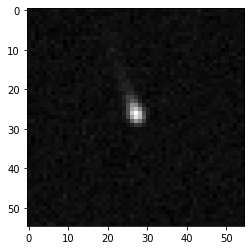

In [91]:
plt.imshow(img, cmap='gray');

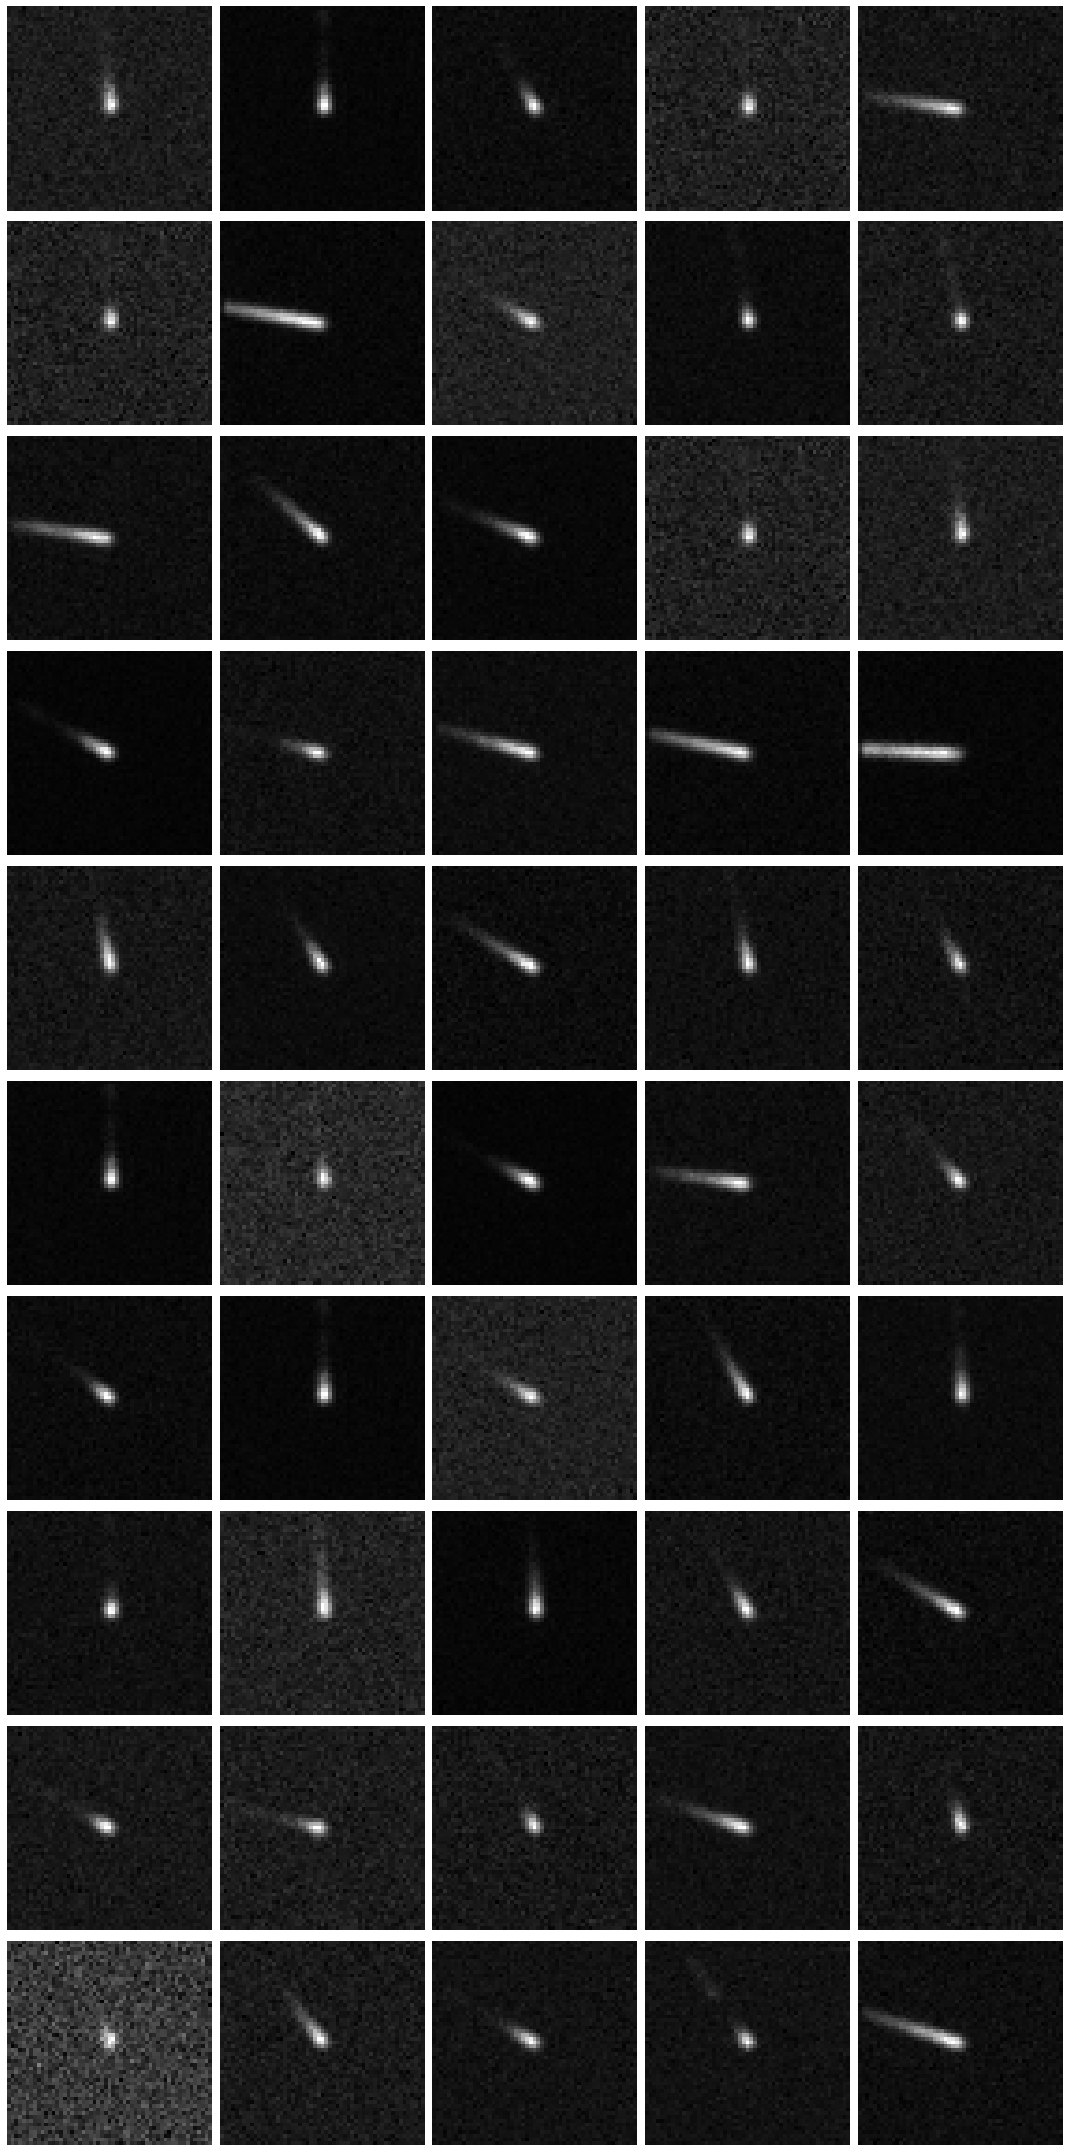

In [92]:
fig, ax = plt.subplots(10, 5, figsize=(15, 30))

for i in range(10):
    for j in range(5):
        idx = np.random.randint(0, len(images))
        img, _ = read_tif(images[idx])
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].axis('off')
        
plt.tight_layout();

# Augmentation

In [93]:
import cv2

In [94]:
images = glob.glob('../images/val/data_C/comet_*.tif')
idx = np.random.randint(0, len(images))
img, meta = read_tif(images[idx])
img.shape, meta

((55, 55),
 {'PolAng': 19, 'TipProb': 0.877, 'ExpTime': 52, 'TipExp': 84, 'eNoise': 117})

In [95]:
def plot_io(img, point):
    im = np.expand_dims(img, axis=0)
    im = np.vstack([im, im, im]).transpose((1, 2, 0))
    im = (im - im.min()) / (im.max() - im.min())
    im[point] = [0, 0, 1]
    
    plt.imshow(im)
    plt.axis('off')

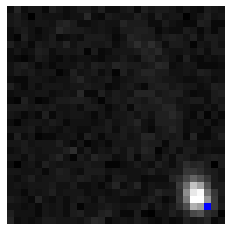

In [96]:
imgc = img[:31, :31]
x, y = 28, 28
plot_io(imgc, (x, y))

### flip

In [97]:
def flip(img, point, subpixel=None, mode=0):
    # mode 0: horizontal flip, 1: vertical flip, 2: diagonal flip
    # TODO: incorporate subpixel
    h, w = img.shape
    if mode == 0:
        flip = cv2.flip(img, 1)
        point = (point[0], w-point[1]-1)
    elif mode == 1:
        flip = cv2.flip(img, 0)
        point = (h-point[0]-1, point[1])
    else:
        flip = cv2.flip(cv2.flip(img, 1), 0)
        point = (h-point[0]-1, w-point[1]-1)
    return flip, point #, subpixel

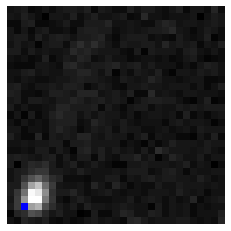

In [98]:
# flip horizontal
plot_io(*flip(imgc, (x, y), mode=0))

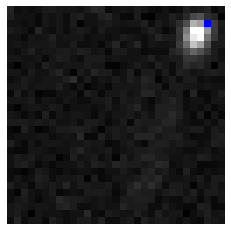

In [99]:
# flip vertical
plot_io(*flip(imgc, (x, y), mode=1))

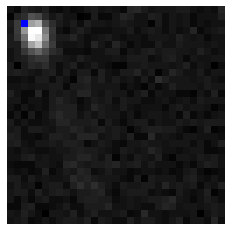

In [100]:
# flip diagonal
plot_io(*flip(imgc, (x, y), mode=2))

### crop

In [101]:
def crop(img, point, size=31):
    sizeo = len(img)
    starti, startj = np.random.randint(0, sizeo-size, size=2)
    
    imgc = img[starti:starti+size, startj:startj+size]
    
#     starti, startj = np.random.randint(0, 10, size=2)
#     endi, endj = np.random.randint(18, 28, size=2)
    
#     imgc = np.clip((0.5 + np.random.random(img.shape)) * img.mean(), img.min(), img.mean()) #np.zeros_like(img) + img.mean()
#     h, w = endi - starti, endj - startj
#     imgc[:h, :w] = img[starti:endi, startj:endj]
    
    return imgc, (point[0] - starti, point[1] - startj)

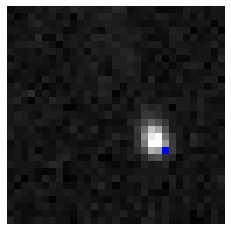

In [102]:
plot_io(*crop(img, (28, 28)))

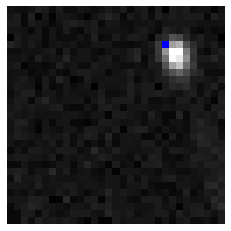

In [103]:
imgc, p = crop(img, (28, 28))
plot_io(*flip(imgc, p, mode=2))

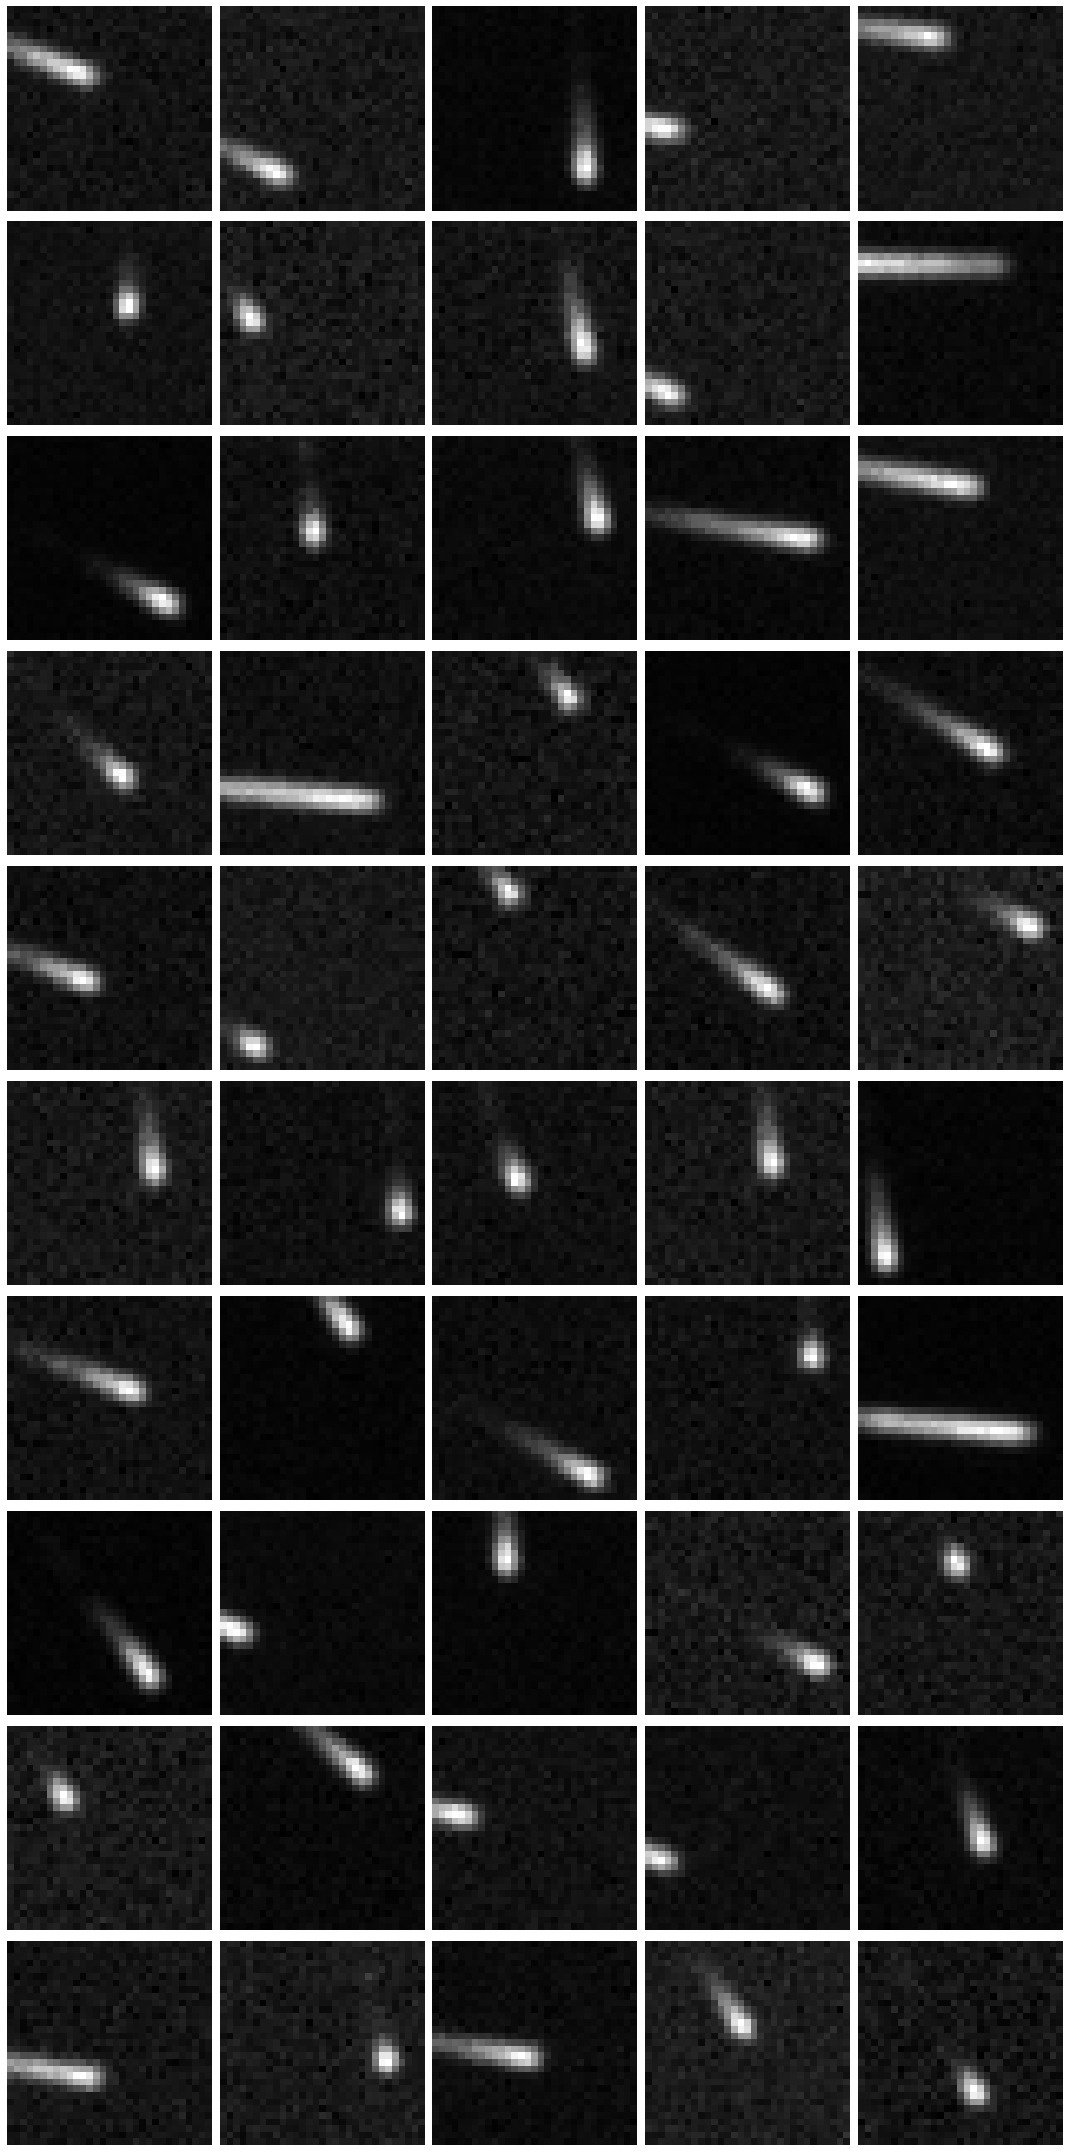

In [104]:
fig, ax = plt.subplots(10, 5, figsize=(15, 30))

for i in range(10):
    for j in range(5):
        idx = np.random.randint(0, len(images))
        img, _ = read_tif(images[idx])
        
        imgc, _ = crop(img, (28, 28))

        ax[i, j].imshow(imgc, cmap='gray')
        ax[i, j].axis('off')
        
plt.tight_layout();

## Data gen

In [108]:
import cv2
import torch
import numpy as np

class RandomFlip(object):
    '''
    Flips the image horizontally (mode=0), vertically (mode=1), 
    or diagonally (mode=2).
    '''

    def __init__(self, prob=0.5):
        assert isinstance(prob, (float, tuple))
        self.prob = prob

    def __call__(self, sample):
        image, tip, subp = sample['image'], sample['tip'], sample['subpixel']

        if np.random.random() < self.prob:
            mode = np.random.choice([0, 1, 2])
            image, tip, subp = self.flip(image, tip, subp, mode=mode)
            
        sample['image'], sample['tip'], sample['subpixel'] = image, tip, subp
        return sample

    def flip(self, img, tip, subpixel, mode=0):
        # mode 0: horizontal flip, 1: vertical flip, 2: diagonal flip
        h, w = img.shape
        
        subpixel = np.array(subpixel).reshape([int(len(subpixel)**0.5)] * 2)
        point = [np.where(subpixel==1)[0][0], np.where(subpixel==1)[1][0]]

        if mode == 0:
            flip = cv2.flip(img, 1)
            tip = (tip[0], w-tip[1]-1)
            point[1] = len(subpixel) - point[1] - 1
        elif mode == 1:
            flip = cv2.flip(img, 0)
            tip = (h-tip[0]-1, tip[1])
            point[0] = len(subpixel) - point[0] - 1
        else:
            flip = cv2.flip(cv2.flip(img, 1), 0)
            tip = (h-tip[0]-1, w-tip[1]-1)
            point[0] = len(subpixel) - point[0] - 1
            point[1] = len(subpixel) - point[1] - 1
        
        subpixel[:] = 0
        subpixel[tuple(point)] = 1
        
        return flip, tip, subpixel.ravel()

class RandomCrop(object):
    '''
    Crops the image randomly in a sample.
    '''

    def __init__(self, size, prob=0.5):
        assert isinstance(prob, (float, tuple))
        self.prob = prob
        self.size = size

    def __call__(self, sample):
        image, tip = sample['image'], sample['tip']
        h, _ = image.shape
        
        if np.random.random() < self.prob:
            # random crop
            starti, startj = np.random.randint(0, h - self.size, size=2)         
        else:
            # center crop
            starti, startj = (h - self.size)//2, (h - self.size)//2            
    
        endi, endj = starti + self.size, startj + self.size            
        image = image[starti:endi, startj:endj]
        tip = (tip[0] - starti, tip[1] - startj)

        sample['image'], sample['tip'] = image, tip
        return sample

In [109]:
import glob
import torch
import tifffile
import numpy as np

class CustomDataGenerator(torch.utils.data.Dataset):

    def __init__(self, root_dir, subpixels=9, transform=None, train=True):
        self.train = train                                                      # returns image file name when True
        self.dir = root_dir
        self.subpixels = subpixels
        self.transform = transform                                              # image transforms for data augmentation
        self.images = sorted(glob.glob(self.dir + '/data_A/comet_*.tif'))

    def __len__(self):
        return len(self.images) * self.subpixels

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # make subpixel as one-hot label
        subpixel = idx // len(self.images)
        subp_label = np.zeros((self.subpixels, 1))
        subp_label[subpixel] = 1
        
        # read image
        fname = self.images[idx % len(self.images)]
        fname.replace('data_A', f'data_{chr(65+subpixel)}')
        img, meta = self.read_tif(fname)                                        # meta (previously facebook :P)
        
        # assuming the comet/polymer tip is centered in the image
        size = len(img)
        tip = (size//2, size//2)
        
        sample = {'image': img, 'tip': tip, 'subpixel': subp_label}

        if self.transform:
            sample = self.transform(sample)
            img, tip, subp_label = sample['image'], sample['tip'], sample['subpixel']

        # normalize image
        img = img.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())
        img = np.expand_dims(img, axis=0)                                       # add channel dimension
        
        # treat tip as a segmentation mask
        mask = np.zeros_like(img[0])
        mask[tip[0], tip[1]] = 1

        subp_label = subp_label.reshape(-1)

        if self.train:
            return img, mask, subp_label
        return img, np.array(tip), np.argmax(subp_label), fname.split('/')[-1][:-4]
    
    def read_tif(self, filename):
        frames = tifffile.TiffFile(filename)
        page = frames.pages[0]
        metadata = page.tags["MicroManagerMetadata"].value
        return tifffile.imread(filename), metadata

In [113]:
from torch.utils.data import DataLoader
from torchvision import transforms

valDataset = CustomDataGenerator(
        '../images/val',
        transform=transforms.Compose([
            RandomFlip(1.0),
            RandomCrop(31, 0.5),
        ]),
        train=False
    )
loader = DataLoader(valDataset, batch_size=256, shuffle=False)

In [114]:
for i, j, k, f in iter(loader):
    img = i.numpy()
    tip = j.numpy()
    label = k
    fname = f
    break

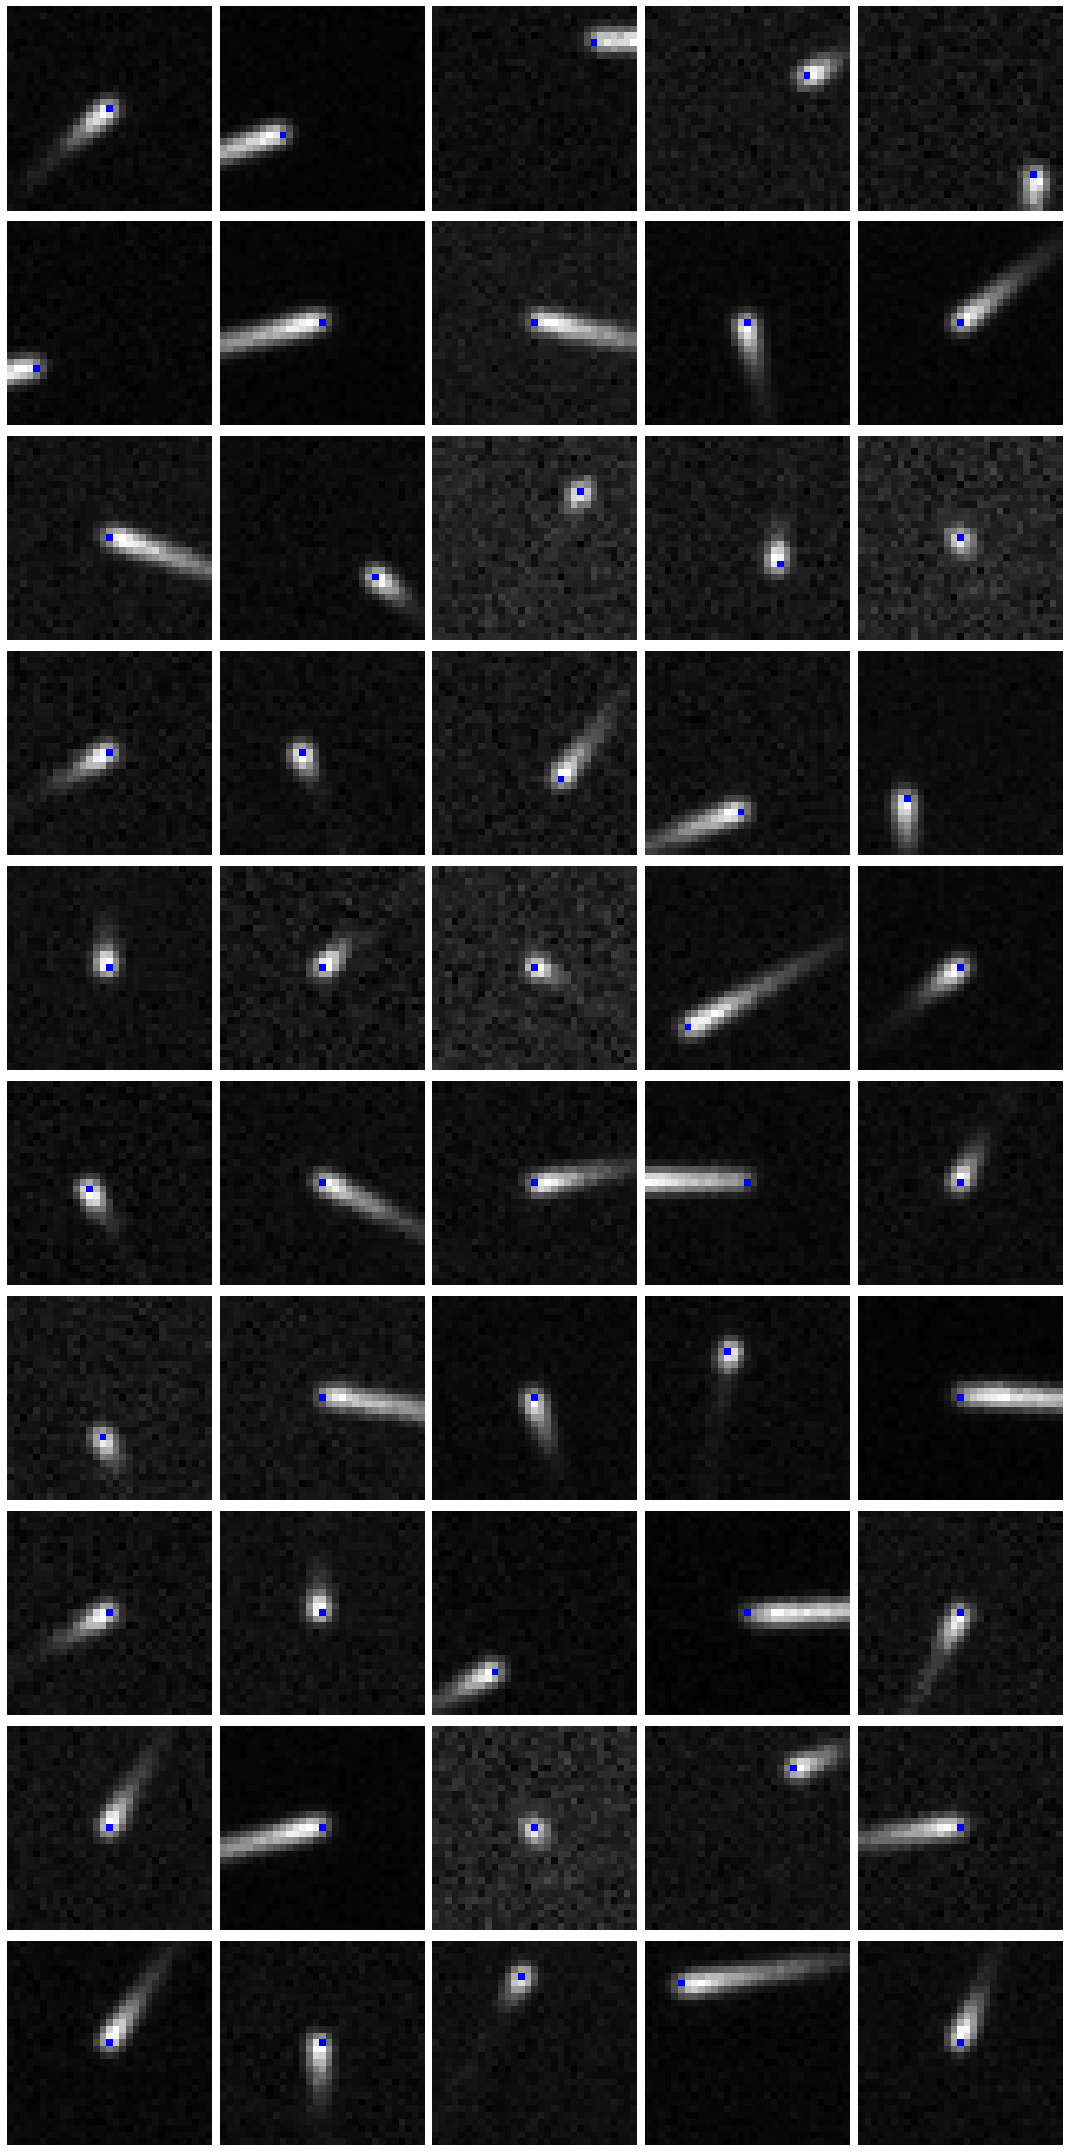

In [115]:
fig, ax = plt.subplots(10, 5, figsize=(15, 30))

for i in range(10):
    for j in range(5):
        idx = np.random.randint(0, len(img))
        
        im = np.vstack([img[idx], img[idx], img[idx]]).transpose((1, 2, 0))
        im[tip[idx][0], tip[idx][1]] = [0, 0, 1]
        ax[i, j].imshow(im)
        ax[i, j].axis('off')
        
plt.tight_layout();

# Model

In [2]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, channel_in, channel_out, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=3, padding='same', dilation=dilation)
        self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size=3, padding='same', dilation=dilation)
        self.bnorm1 = nn.BatchNorm2d(channel_out)
        self.bnorm2 = nn.BatchNorm2d(channel_out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.activation(self.bnorm1(conv1))
        conv2 = self.conv2(conv1)
        conv2 = self.activation(self.bnorm2(conv2))
        return conv2

class Downsample(nn.Module):
    def __init__(self, channel_in):
        super().__init__()
        self.downsample = nn.Conv2d(channel_in, channel_in * 2, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.downsample(x)

class Upsample(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=2, stride=2)

    def forward(self, x):
        return self.conv_transpose(x)

class Linear(nn.Module):
    def __init__(self, in_features, out_features, activation=None):
        super().__init__()
        self.activation = activation
        self.layer = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        if self.activation == 'relu':
            return self.relu(self.layer(x))
        return self.layer(x)  

class UNet(nn.Module):
    def __init__(self, channels, classes=1, subpixels=9):
        super(UNet, self).__init__()
        self.CHANNELS = channels
        self.CLASSES = classes
        self.SUBPIXELS = subpixels

        self.inp = ConvBlock(self.CHANNELS, 64)

        self.stage1 = ConvBlock(128, 128, dilation=1)
        self.stage2 = ConvBlock(256, 256, dilation=1)
        self.stage3 = ConvBlock(512, 512, dilation=2)

        self.down1 = Downsample(64)
        self.down2 = Downsample(128)
        self.down3 = Downsample(256)

        self.up1 = Upsample(512, 256)
        self.up2 = Upsample(256, 128)
        self.up3 = Upsample(128, 64)

        self.stage3i = ConvBlock(512, 256, dilation=2)
        self.stage2i = ConvBlock(256, 128, dilation=1)
        self.stage1i = ConvBlock(128, 64, dilation=1)

        self.out = nn.Conv2d(64, self.CLASSES, kernel_size=1)

        # subpixel classifier
        self.linear1 = Linear(512 * 4 * 4, 512, activation='relu')
        self.linear2 = Linear(512, 256, activation='relu')
        self.linear3 = Linear(256, self.SUBPIXELS, activation=None)

    def forward(self, x):
        size = x.shape[-1]
        
        a1 = self.inp(x)
        d1 = self.down1(a1)

        a2 = self.stage1(d1)
        d2 = self.down2(a2)

        a3 = self.stage2(d2)
        d3 = self.down3(a3)

        a4 = self.stage3(d3)
        u1 = self.up1(a4)

        c1 = self.stage3i(torch.cat([a3, u1], dim=1))
        u2 = self.up2(c1)

        c2 = self.stage2i(torch.cat([a2, u2], dim=1))
        u3 = self.up3(c2)
        u3 = u3[:, :, :size, :size]

        c3 = self.stage1i(torch.cat([a1, u3], dim=1))
        mask = self.out(c3)

        # subpixel classifier
        flat = torch.flatten(a4, start_dim=1)
        
        l1 = self.linear1(flat)
        l2 = self.linear2(l1)
        subp = self.linear3(l2)

        return mask, subp

In [148]:
from torchsummary import summary
model = UNet(1)
summary(model, (1, 31, 31))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
       BatchNorm2d-2           [-1, 64, 31, 31]             128
              ReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 31, 31]          36,928
       BatchNorm2d-5           [-1, 64, 31, 31]             128
              ReLU-6           [-1, 64, 31, 31]               0
         ConvBlock-7           [-1, 64, 31, 31]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
        Downsample-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
      BatchNorm2d-14          [-1, 128,

# Analyse predictions

In [203]:
import glob

In [204]:
def read_tif(filename):
    frames = tifffile.TiffFile(filename)
    page = frames.pages[0]
    metadata = page.tags["MicroManagerMetadata"].value
    return tifffile.imread(filename), metadata

In [205]:
images = glob.glob('../res/prediction/*.tif')

In [206]:
i, m = read_tif(images[0])
m

{'tip': '24,12', 'tip_gt': '24,12', 'subpixel': 'I', 'subpixel_gt': 'A'}

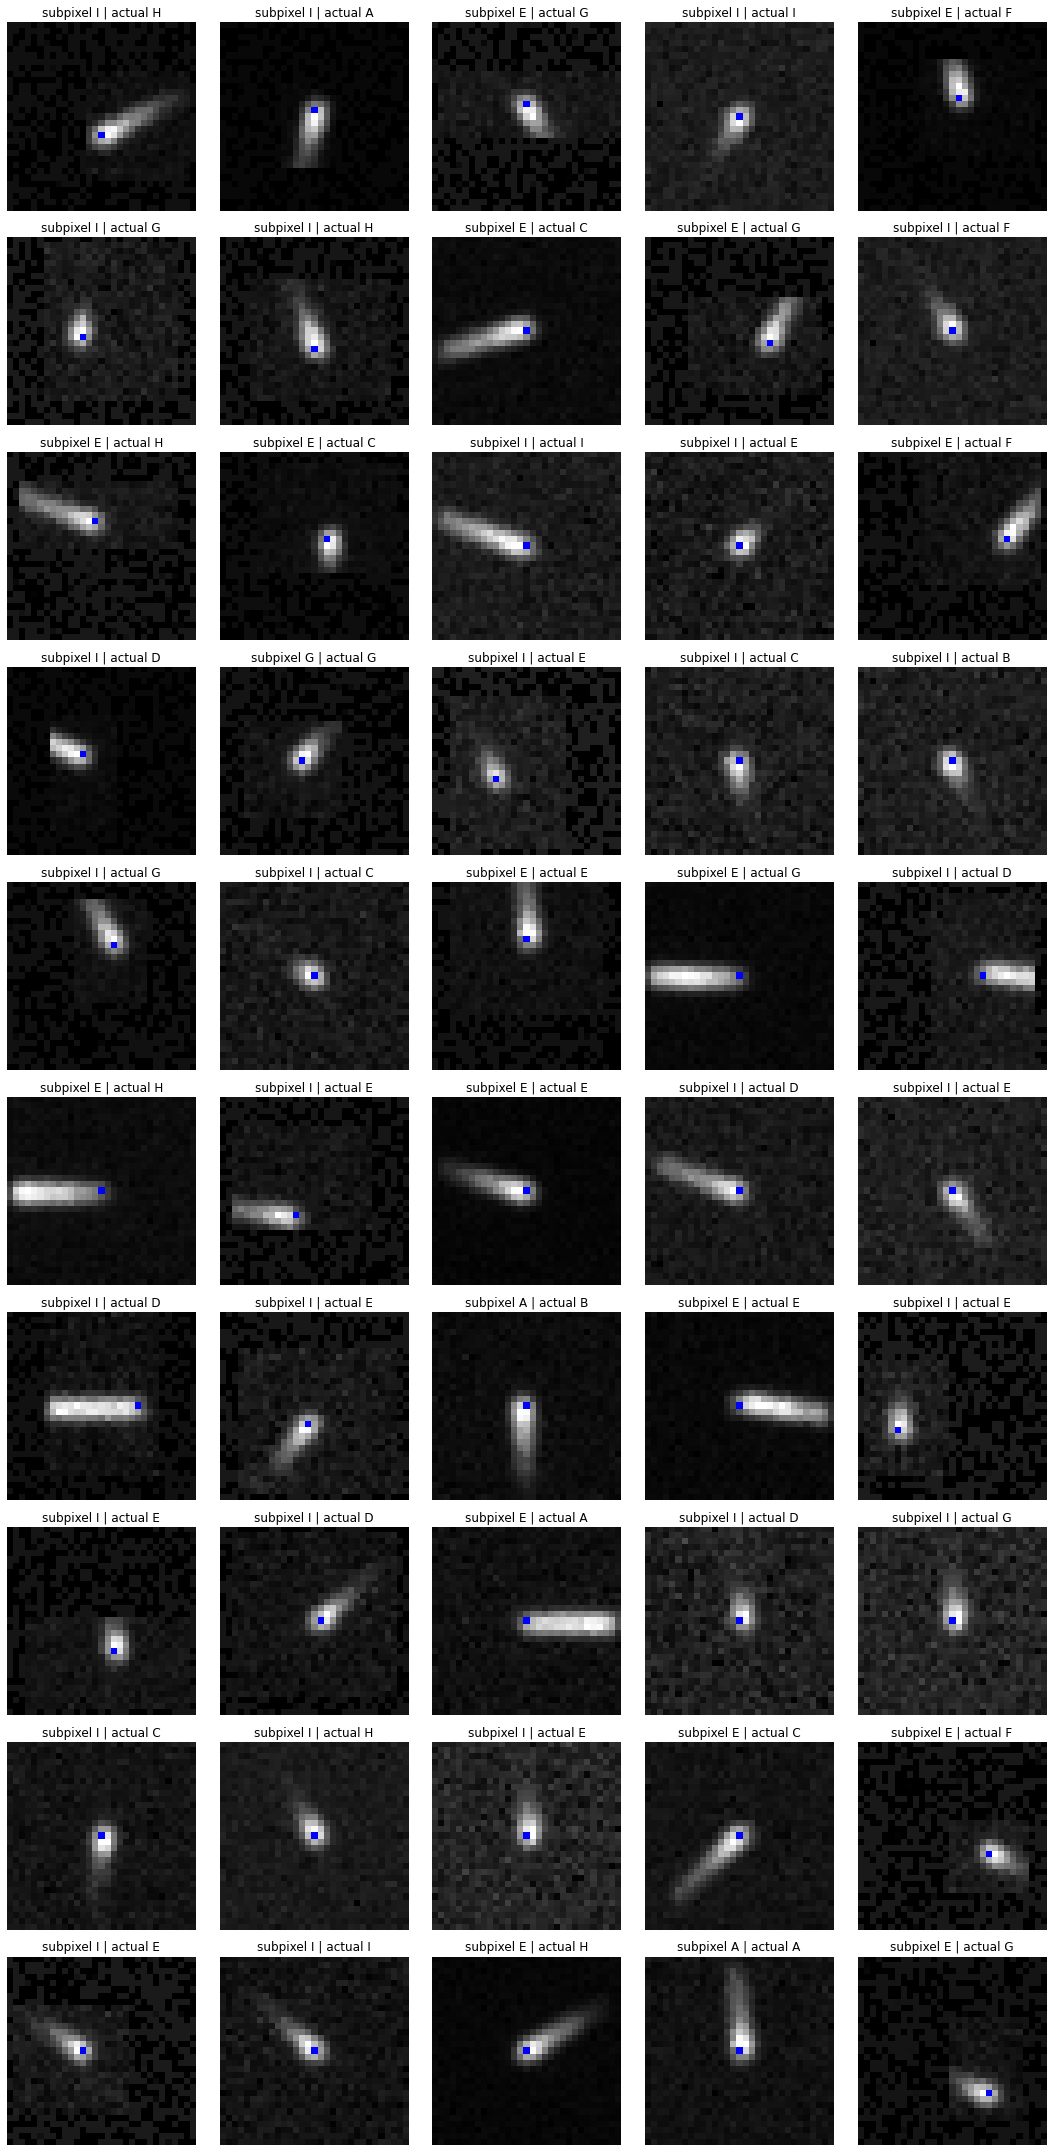

In [215]:
fig, ax = plt.subplots(10, 5, figsize=(15, 30))

for i in range(10):
    for j in range(5):
        idx = np.random.randint(0, len(images))
        img, meta = read_tif(images[idx])
        img = np.expand_dims(img, axis=0)
        
        im = np.vstack([img]*3).transpose((1, 2, 0))
        
        tip = meta['tip'].split(',')
        tip_gt = meta['tip_gt'].split(',')
        
        if int(tip_gt[0])==int(tip[0]) and int(tip_gt[1])==int(tip[1]):        
            im[int(tip_gt[0]), int(tip_gt[1])] = [0, 0, 1]
            ax[i, j].set_title(f"subpixel {meta['subpixel']} | actual {meta['subpixel_gt']}")
        else:
            im[int(tip[0]), int(tip[1])] = [1, 0, 0]
            im[int(tip_gt[0]), int(tip_gt[1])] = [0, 0, 1]
            ax[i, j].set_title(f"ERR: subpixel {meta['subpixel']} | actual {meta['subpixel_gt']}")
        ax[i, j].imshow(im)        
        ax[i, j].axis('off')
        
plt.tight_layout();

# Test

In [36]:
test_image = tifffile.imread('../../Eb1WT100mscrop1f1_10.tif')
t, h, w = test_image.shape
test_image.min(), test_image.max()

(69, 876)

In [37]:
# idx = 0
# for k in range(t):
#     for i in range(0, h-31, 31):
#         for j in range(0, w-31, 31):
#             idx += 1
#             im = test_image[k, i:i+31, j:j+31]
#             tifffile.imwrite(
#                 f'../images/test/comet_' + f'{idx}.tif'.rjust(9, '0'),
#                 data=im
#             )

In [38]:
def read_tif(filename):
    frames = tifffile.TiffFile(filename)
    page = frames.pages[0]
    metadata = page.tags["MicroManagerMetadata"].value
    return tifffile.imread(filename), metadata

In [39]:
fnames = glob.glob('../images/test/comet_*.tif')

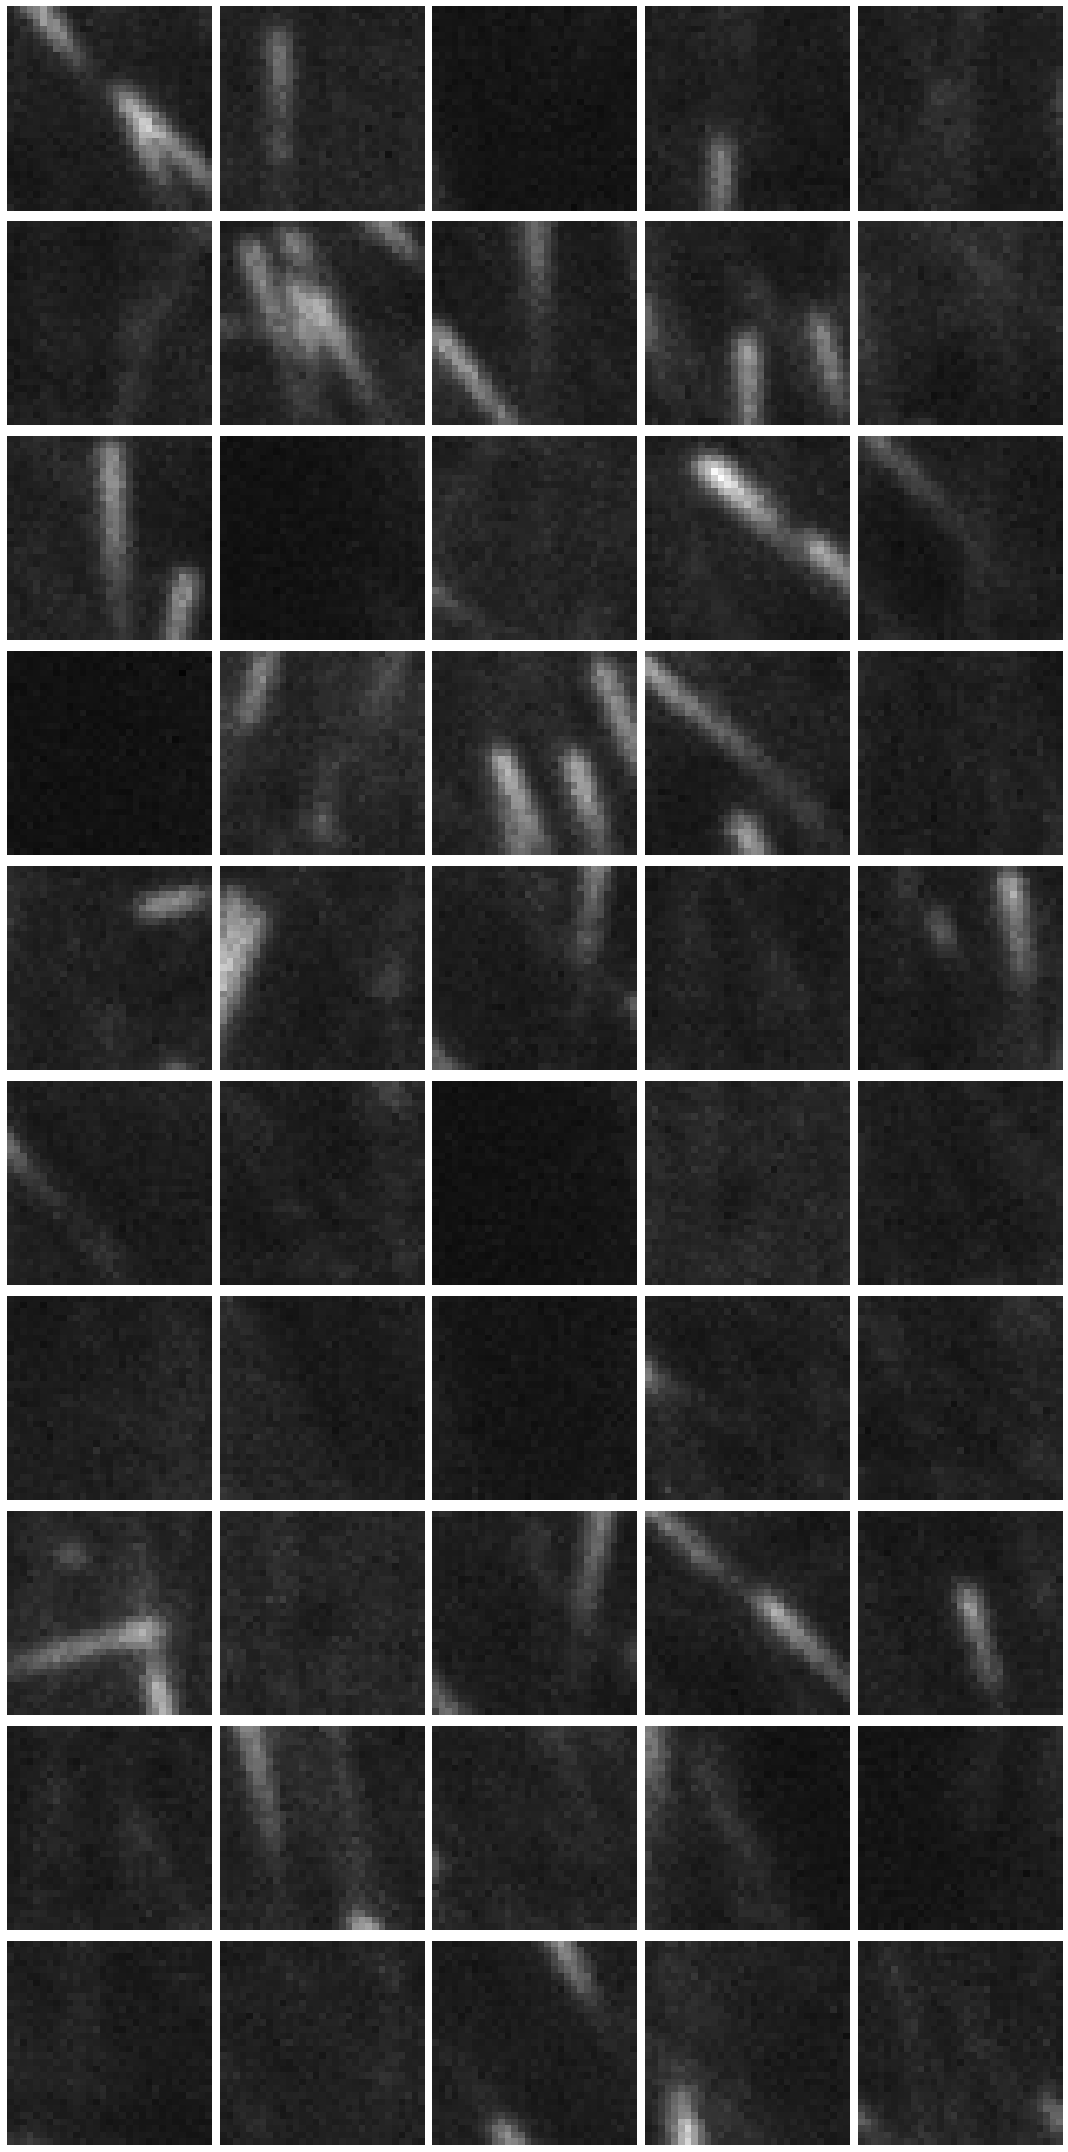

In [42]:
fig, ax = plt.subplots(10, 5, figsize=(15, 30))

idx = 0
for i in range(10):
    for j in range(5):
        im = tifffile.imread(fnames[idx])
#         starti, startj = i*31, j*31
#         im = test_image[0, starti:starti+31, startj:startj+31]
        ax[i, j].imshow(im, cmap='gray', vmin=test_image.min(), vmax=test_image.max())        
        ax[i, j].axis('off')
        idx += 1
        
plt.tight_layout();